## Used packages

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant

warnings.filterwarnings("ignore")

## Creating samples LHC 

In [6]:
# Create an instance of the model which is usable with the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [7]:
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [8]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=100,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results


100%|████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


## Preprocess data samples LHC 

In [9]:
experiments_unc =experiments.iloc[:,0:19]
df = pd.DataFrame(outcomes) 

In [10]:
df

,A.1 Total Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.3 Total Costs,A.3_Expected Number of Deaths,A.3_Expected Annual Damage,A.4 Total Costs,A.4_Expected Number of Deaths,A.4_Expected Annual Damage,A.5 Total Costs,A.5_Expected Number of Deaths,A.5_Expected Annual Damage,RfR Total Costs,Expected Evacuation Costs
0,2.323671e+09,1.964433,2.323671e+09,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.335778e+06,0.002768,5.335778e+06,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
1,9.578766e+07,0.069348,9.578766e+07,3.303224e+08,0.300853,3.303224e+08,2.166246e+09,3.640803,2.166246e+09,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
2,2.947949e+09,2.011773,2.947949e+09,9.442973e+08,0.804883,9.442973e+08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
3,8.981577e+07,0.075605,8.981577e+07,2.006083e+07,0.022902,2.006083e+07,0.000000e+00,0.000000,0.000000e+00,5.857976e+07,0.031095,5.857976e+07,4.340127e+08,0.440013,4.340127e+08,0.0,0.0
4,1.535753e+08,0.121311,1.535753e+08,6.612725e+07,0.069250,6.612725e+07,1.181851e+09,2.246591,1.181851e+09,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.845748e+09,1.968410,2.845748e+09,2.730858e+07,0.025769,2.730858e+07,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
96,2.551623e+09,1.981698,2.551623e+09,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
97,5.629678e+07,0.033127,5.629678e+07,4.042577e+07,0.031830,4.042577e+07,1.781239e+08,0.259931,1.781239e+08,3.396756e+06,0.001517,3.396756e+06,0.000000e+00,0.000000,0.000000e+00,0.0,0.0
98,0.000000e+00,0.000000,0.000000e+00,1.770599e+08,0.170657,1.770599e+08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,7.534704e+08,0.682301,7.534704e+08,0.0,0.0


In [11]:
df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df["A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

In [12]:
df_feature_importance_out = df[["Expected Evacuation Costs","Expected Annual Damage", "Expected Number of Deaths","A.5_Expected Number of Deaths","A.5_Expected Annual Damage"]]

## Feature importance

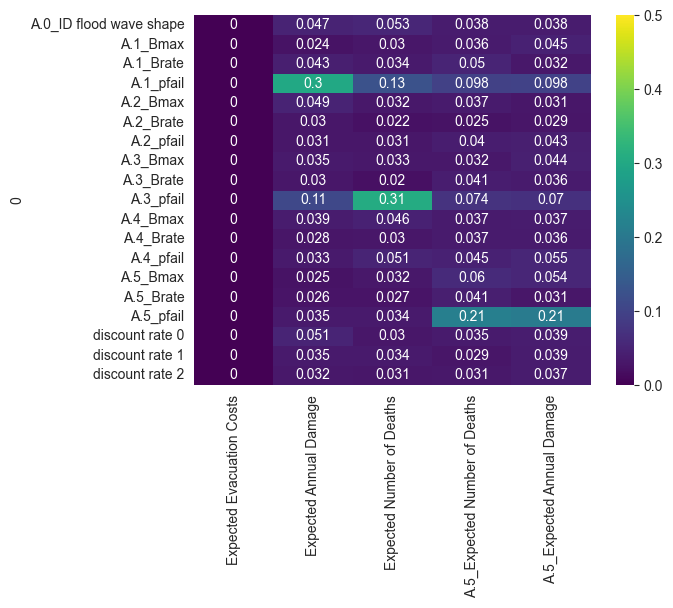

In [13]:
x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,vmax=0.5)
plt.show()

## Filter important uncertainties and create samples SOBOL 

In [14]:
dike_model_1, planning_steps = get_model_for_problem_formulation(3)

zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model_1.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [15]:
dele = []
for x in dike_model_1.uncertainties:
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail"]:
        dele.append(x.name)
for i in dele:
    dike_model_1.uncertainties.__delitem__(i)


dike_model_1.constants.extend(Constant("discount rate 0",1))
dike_model_1.constants.extend(Constant("discount rate 1",1))
dike_model_1.constants.extend(Constant("discount rate 2",1))

dike_model_1.constants.extend(Constant('A.0_ID flood wave shape',1))

dike_model_1.constants.extend(Constant('A.1_Bmax',190))
dike_model_1.constants.extend(Constant('A.1_Brate',1.5))

dike_model_1.constants.extend(Constant('A.2_Bmax',190))
dike_model_1.constants.extend(Constant('A.2_Brate',1.5))

dike_model_1.constants.extend(Constant('A.3_Bmax',190))
dike_model_1.constants.extend(Constant('A.3_Brate',1.5))

dike_model_1.constants.extend(Constant('A.4_Bmax',190))
dike_model_1.constants.extend(Constant('A.4_Brate',1.5))

dike_model_1.constants.extend(Constant('A.5_Bmax',190))
dike_model_1.constants.extend(Constant('A.5_Brate',1.5))


In [16]:
with SequentialEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=20,policies=policy0,uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = results


100%|████████████████████████████████████████| 240/240 [01:49<00:00,  2.20it/s]


## Preprocess data samples SOBOL

In [17]:
experiments_unc =experiments.iloc[:,0:5]

In [18]:
df =pd.DataFrame(outcomes)

In [19]:
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]

outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]
outcomes["Expected Annual Damage"] = df["Expected Annual Damage"]

## Feature importance (not required but nice to know)

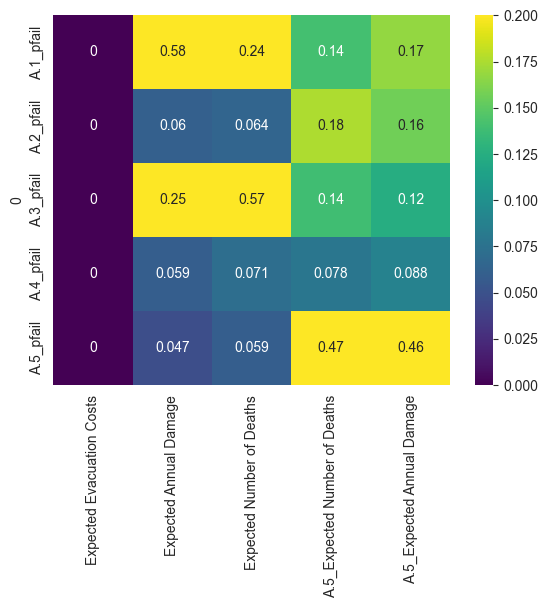

In [20]:
df_feature_importance_out = df[["Expected Evacuation Costs","Expected Annual Damage", "Expected Number of Deaths","A.5_Expected Number of Deaths","A.5_Expected Annual Damage"]]

x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, vmax=0.2)
plt.show()

## SOBOL analysis 

In [21]:
problem = get_SALib_problem(dike_model_1.uncertainties)

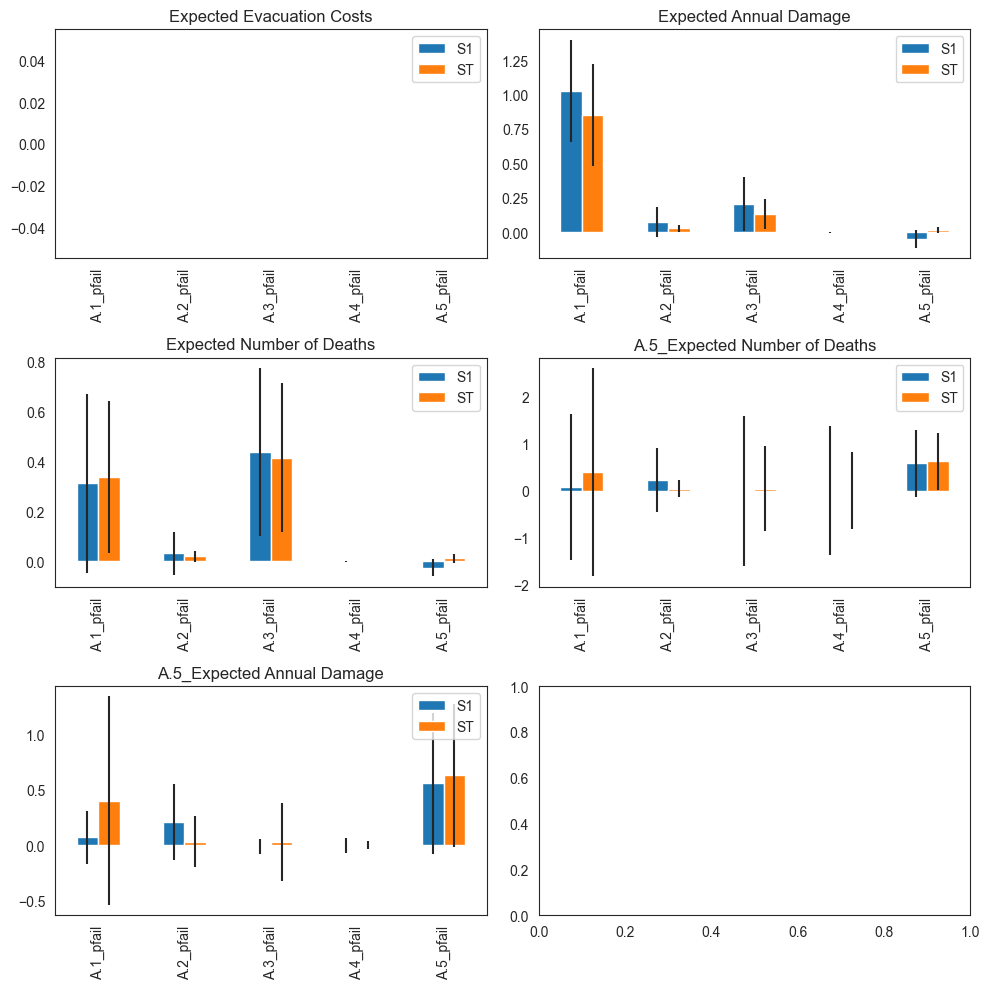

In [22]:
sns.set_style('white')
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax = ax.flatten()

for index,kpi in enumerate(df_feature_importance_out.columns):
    Si = sobol.analyze(problem,np.array(outcomes[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    ax[index].title.set_text(kpi) 
    indices.plot.bar(yerr=err.values.T,ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

In [23]:
total_Si, first_Si, second_Si = Si.to_df()

## PRIM analyses 

### PRIM for A.5 outcomes

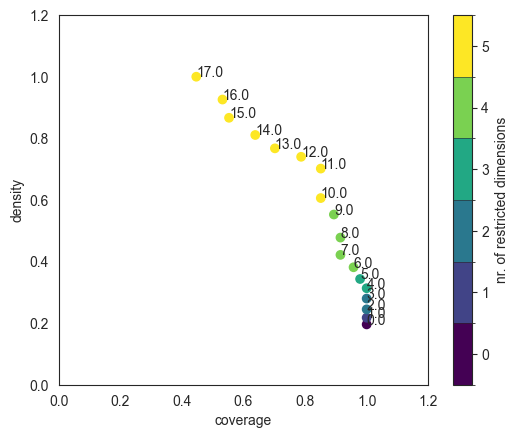

In [24]:


y = ((df_feature_importance_out["A.5_Expected Number of Deaths"] > list(np.sort(df_feature_importance_out["A.5_Expected Number of Deaths"]))[int(0.80* len(df_feature_importance_out["A.5_Expected Number of Deaths"]))])
    |(df_feature_importance_out['A.5_Expected Annual Damage'] > list(np.sort(df_feature_importance_out['A.5_Expected Annual Damage']))[int(0.80* len(df_feature_importance_out['A.5_Expected Annual Damage']))])
     )

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

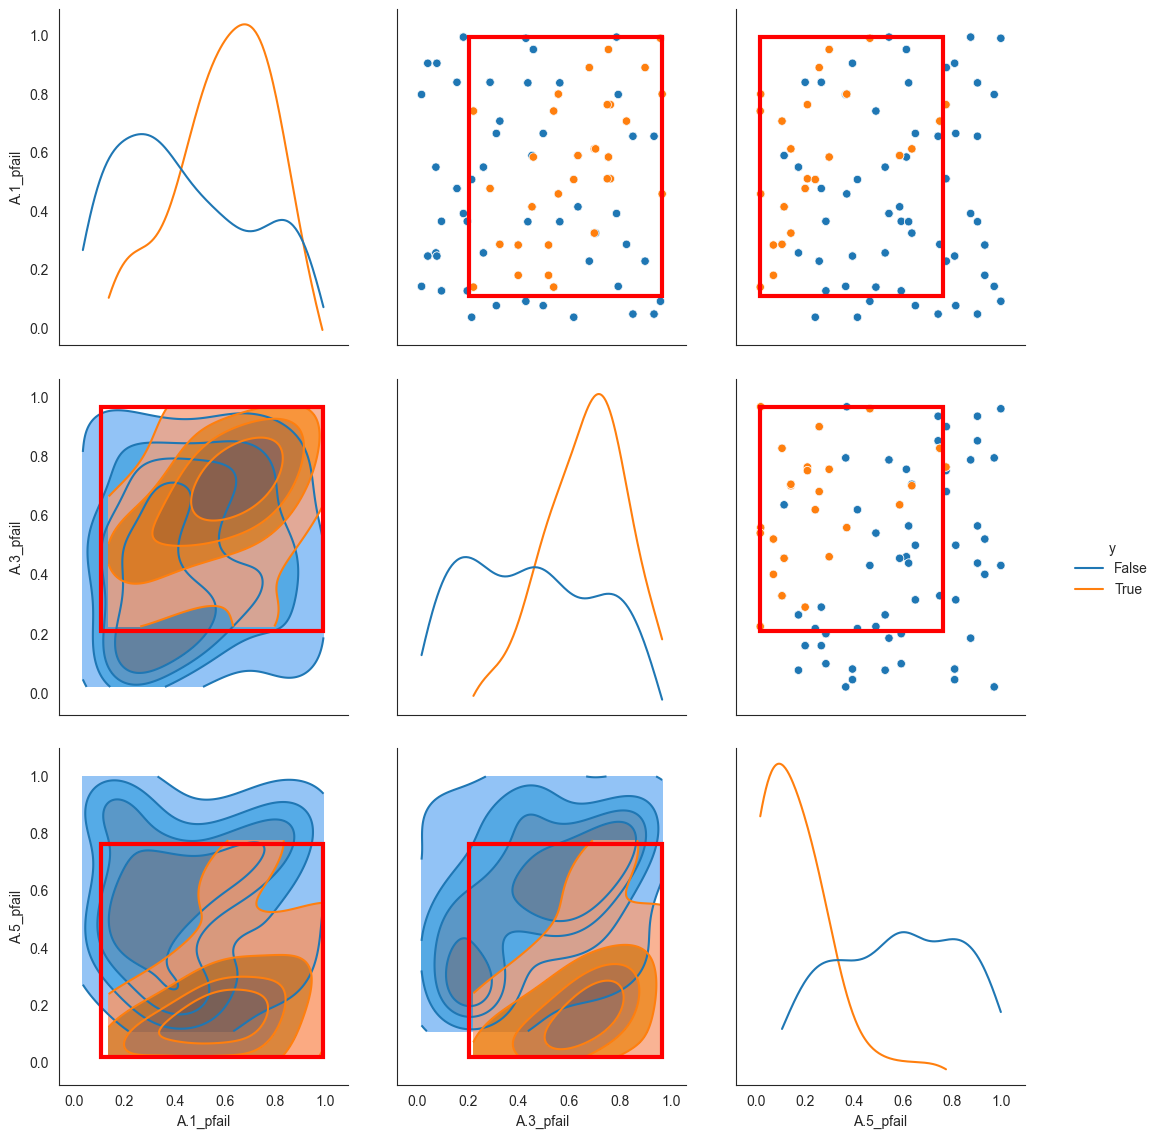

In [41]:
box1.select(5)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

coverage      0.978723
density       0.343284
id            5.000000
k            46.000000
mass          0.558333
mean          0.343284
n           134.000000
res_dim       3.000000
Name: 5, dtype: float64

              box 5                             
                min       max  qp value qp value
A.5_pfail  0.017127  0.761396       NaN  0.06363
A.3_pfail  0.207071  0.965547  0.046228      NaN
A.1_pfail  0.106890  0.992703  0.268585      NaN


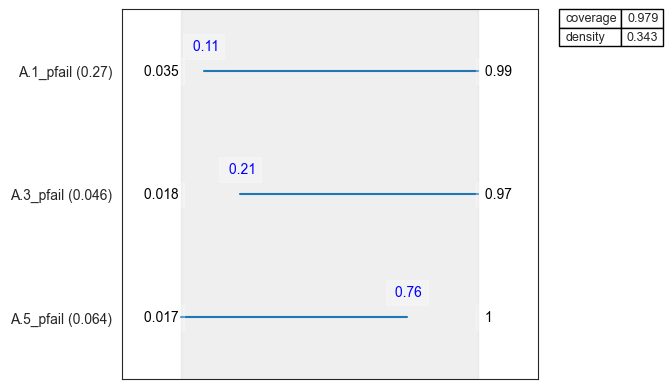

In [42]:
box1.inspect(5)
box1.inspect(5, style="graph")
plt.show()  

In [46]:
pd.DataFrame(box1.inspect(0, style='data')[0][1]).to_csv('data\para_space_A5.csv')

### PRIM for general outcomes 

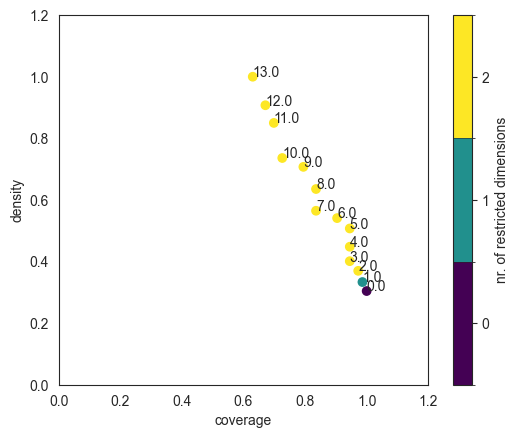

In [47]:
y = ((df_feature_importance_out['Expected Number of Deaths'] >= list(np.sort(df_feature_importance_out["Expected Number of Deaths"]))[int(0.80* len(df_feature_importance_out['Expected Number of Deaths']))])
     |(df_feature_importance_out['Expected Annual Damage'] >= list(np.sort(df_feature_importance_out["Expected Annual Damage"]))[int(0.80* len(df_feature_importance_out['Expected Annual Damage']))])
     )
# (df_feature_importance_out["Total Costs"] >= list(np.sort(df_feature_importance_out["Total Costs"]))[int(0.80* len(df_feature_importance_out["Total Costs"]))]) 
#      |
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff(annotated=True)
plt.show()

 22%|█████████                                | 22/100 [04:33<16:10, 12.44s/it]


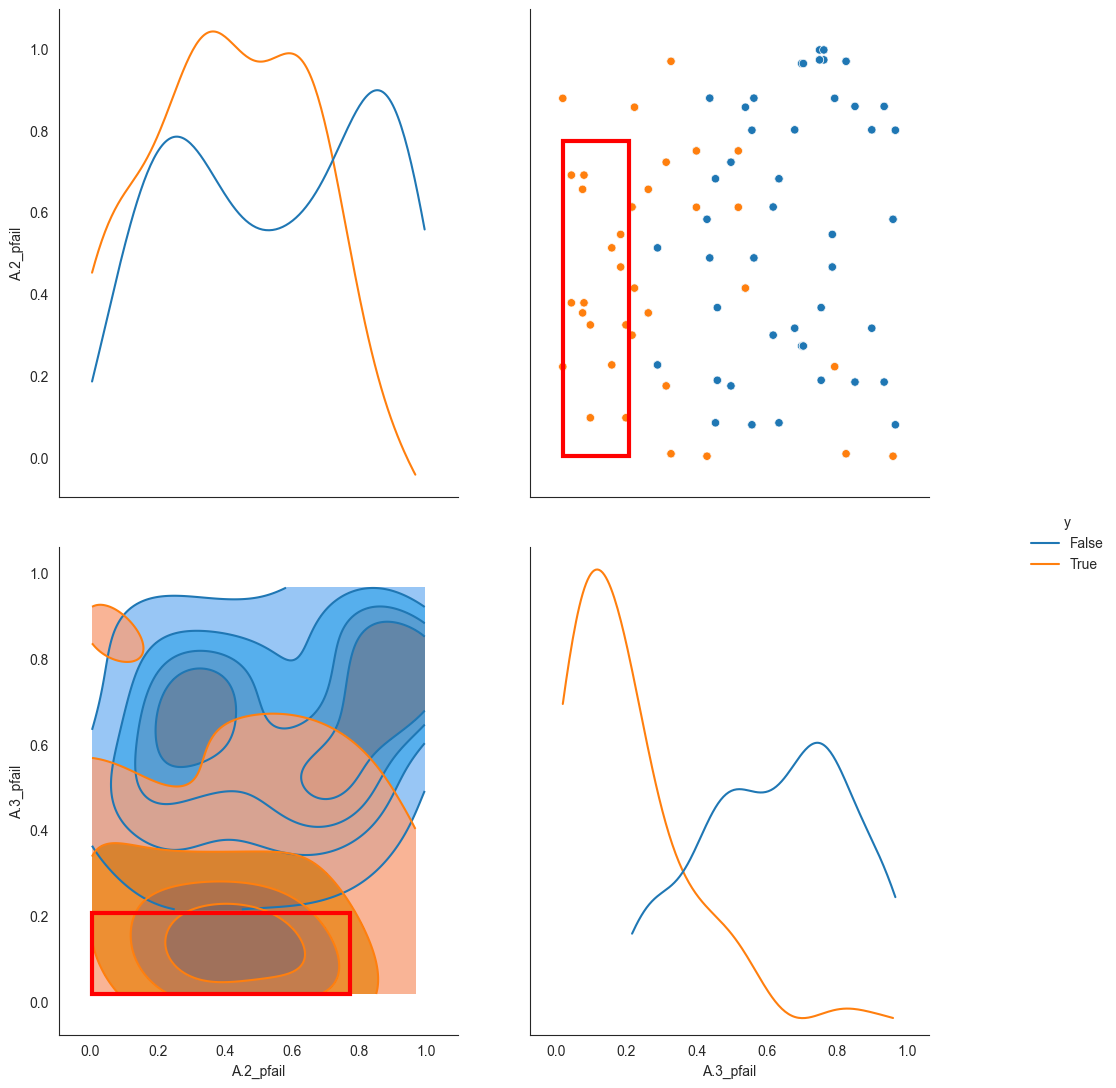

In [37]:
box2.select(13)
box2.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

coverage     0.630137
density      1.000000
id          13.000000
k           46.000000
mass         0.191667
mean         1.000000
n           46.000000
res_dim      2.000000
Name: 13, dtype: float64

             box 13                                 
                min       max qp value      qp value
A.3_pfail  0.018499  0.207071      NaN  6.990737e-20
A.2_pfail  0.004499  0.775145      NaN  1.000000e+00


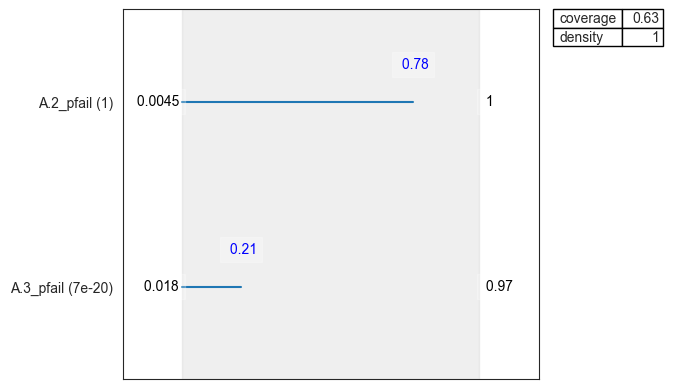

In [38]:
box2.inspect(13)
box2.inspect(13, style="graph")
plt.show()

In [39]:
pd.DataFrame(box2.inspect(13, style='data')[0][1]).to_csv('data\para_space_all.csv')

### Selection reference scenarios

In [49]:
from Convience_fun import create_scenario

In [50]:
import multirange as mr

df_param_space_A5 = pd.read_csv('data/para_space_A5.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"})
df_param_space_all = pd.read_csv('data/para_space_all.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"})

dike_model, planning_steps = get_model_for_problem_formulation(3)


def create_scenario_from_box(all, a5):
    para_list = []
    for uncertainty in dike_model.uncertainties:
        # print((variable in df_param_space_A5.Variable))
        variable = uncertainty.name
        # print(variable)
        if (variable in list(df_param_space_A5.Variable)) & (variable in list(df_param_space_all.Variable)) & (
                all + a5 == 2):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[
                    0]) * 10000
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[
                    0]) * 10000

            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[
                    0]) * 10000
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[
                    0]) * 10000

            boundaries = mr.overlap(range(int(min_1), int(max_1)), range(int(min_2), int(max_2)))
            para_list.append((boundaries.start + (boundaries.stop - boundaries.start) / 2) / 10000)
            print((boundaries.start + (boundaries.stop - boundaries.start) / 2) / 10000)
        elif (variable in list(df_param_space_A5.Variable)) & (a5 == True):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[0])
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[0])

            para_list.append((min_1 + (max_1 - min_1) / 2))
        elif (variable in list(df_param_space_all.Variable)) & (all == True):
            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[0])

            para_list.append((min_2 + (max_2 - min_2) / 2))
        elif variable.startswith("d"):
            para_list.append(3.5)
        elif variable == "A.0_ID flood wave shape":
            para_list.append(17)
        elif variable.endswith("Brate"):
            para_list.append(1.5)
        else:
            para_list.append((uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2))

    return create_scenario(para_list)


Scenarios_MOEA = [create_scenario_from_box(all=True, a5=True), create_scenario_from_box(all=True, a5=False),
                  create_scenario_from_box(all=False, a5=True)]

In [51]:
import pickle

In [53]:
with open("data\ScenariosOpenExplo", 'wb') as file:
    pickle.dump(Scenarios_MOEA, file) 

